In [39]:
# 영화 리뷰 텍스트 감성 분석하기 프로젝트

In [1]:
# !pip install konlpy
# !pip install gensim
# !git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git
# %cd Mecab-ko-for-Google-Colab/
# !bash install_mecab-ko_on_colab_light_220429.sh
# !wget https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt
# !wget https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt

In [2]:
# 기본 라이브러리
import numpy as np 
import pandas as pd  
from collections import Counter  
from tqdm import tqdm  
import matplotlib.pyplot as plt  
# 한국어 형태소 분석기 
from konlpy.tag import Mecab  # Mecab 형태소 분석기 
# 학습, 검증 데이터 분리
from sklearn.model_selection import train_test_split  # 데이터셋을 train/test로 나누기
# Word2Vec 임베딩 관련 라이브러리
import gensim
from gensim.models import Word2Vec  # Word2Vec 모델 생성 및 학습
from gensim.models.keyedvectors import Word2VecKeyedVectors  # 학습된 Word2Vec 벡터 불러오기용
import torch  
from torch import nn, optim  
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F

In [3]:
train_data = pd.read_table('ratings_train.txt')
test_data = pd.read_table('ratings_test.txt')

train_data.drop_duplicates(subset=['document'], inplace=True)
train_data.dropna(how='any', inplace=True)
test_data.drop_duplicates(subset=['document'], inplace=True)
test_data.dropna(how='any', inplace=True)

train_data, valid_data = train_test_split(train_data, test_size=0.2, random_state=42)

In [4]:
# 형태소 분석기: Mecab 사용
tokenizer = Mecab()
# 불용어 리스트: 제거할 단어들
stopwords = ['의', '가', '이', '은', '들', '는', '좀', '잘', '걍', '과', '도', '를', '으로', '자', '에', '와', '한', '하다']
# 문장 전처리: 형태소 분석 후 불용어 제거
def preprocess_sentence(sentence, tokenizer, stopwords):
    tokens = tokenizer.morphs(sentence)  # 문장을 형태소 단위로 분해
    return [word for word in tokens if word not in stopwords]  # 불용어 제거 후 반환
# 단어 리스트를 인덱스 리스트로 변환 (<UNK> 처리 포함)
def wordlist_to_indexlist(wordlist, word_to_index):
    return [word_to_index.get(word, word_to_index['<UNK>']) for word in wordlist]
# 전체 데이터 로딩 및 전처리
def load_data(train_data, valid_data, test_data, num_words=10000):
    # 각 문장들을 토큰화하고 불용어 제거한 결과
    X_train_tokens = [preprocess_sentence(s, tokenizer, stopwords) for s in train_data['document']]
    X_valid_tokens = [preprocess_sentence(s, tokenizer, stopwords) for s in valid_data['document']]
    X_test_tokens  = [preprocess_sentence(s, tokenizer, stopwords) for s in test_data['document']]
    # 전체 훈련 데이터에서 단어 빈도수 집계 
    words = np.concatenate(X_train_tokens).tolist()
    counter = Counter(words).most_common(num_words - 4)
    # vocab 구성: 특수 토큰 4개 + 자주 등장하는 단어들
    vocab = ['<PAD>', '<UNK>', '<BOS>', '<EOS>'] + [word for word, _ in counter]
    # 단어 -> 인덱스 맵핑
    word_to_index = {word: idx for idx, word in enumerate(vocab)}
    # 토큰 시퀀스 -> 인덱스 시퀀스로 변환 (OOV는 <UNK>로 처리)
    X_train = [wordlist_to_indexlist(x, word_to_index) for x in X_train_tokens]
    X_valid = [wordlist_to_indexlist(x, word_to_index) for x in X_valid_tokens]
    X_test  = [wordlist_to_indexlist(x, word_to_index) for x in X_test_tokens]
    # 레이블 추출
    y_train = np.array(train_data['label'])
    y_valid = np.array(valid_data['label'])
    y_test  = np.array(test_data['label'])
    # 결과 반환: 시퀀스, 토큰, 레이블, 단어 인덱스 매핑
    return X_train, X_train_tokens, y_train, X_valid, X_valid_tokens, y_valid, X_test, X_test_tokens, y_test, word_to_index

In [5]:
# Keras의 pad_sequences(pre, pre) 동작을 그대로 구현한 함수
def pad_sequences_pre(sequences, max_len, padding_value=0):
    processed = []
    for seq in sequences:
        # max_len보다 길면 앞에서 자름 (pre-truncating)
        seq = torch.tensor(seq[:max_len], dtype=torch.long)
        if len(seq) < max_len:
            # max_len보다 짧으면 앞에 padding_value를 채워넣음 (pre-padding)
            pad_len = max_len - len(seq)
            pad = torch.full((pad_len,), padding_value, dtype=torch.long)
            seq = torch.cat((pad, seq), dim=0)
        else:
            # 혹시 모를 예외 처리를 위해 다시 한 번 max_len만큼 자름
            seq = seq[-max_len:]
        processed.append(seq)
    # 리스트를 텐서로 묶어서 반환 (shape: [batch_size, max_len])
    return torch.stack(processed)
# 시퀀스 최대 길이 설정
max_len = 50
# 훈련, 검증, 테스트 데이터를 패딩 적용하여 텐서로 변환
X_train_pad = pad_sequences_pre(X_train, max_len=max_len)
X_valid_pad = pad_sequences_pre(X_valid, max_len=max_len)
X_test_pad  = pad_sequences_pre(X_test,  max_len=max_len)


train_inputs = torch.LongTensor(X_train_pad)
train_labels = torch.FloatTensor(y_train)

valid_inputs = torch.LongTensor(X_valid_pad)
valid_labels = torch.FloatTensor(y_valid)

test_inputs  = torch.LongTensor(X_test_pad)
test_labels  = torch.FloatTensor(y_test)

train_dataset = TensorDataset(train_inputs, train_labels)
valid_dataset = TensorDataset(valid_inputs, valid_labels)
test_dataset  = TensorDataset(test_inputs, test_labels)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=64)
test_loader  = DataLoader(test_dataset, batch_size=64)

In [6]:
# 학습용 전체 말뭉치 구성
total_corpus = X_train_tokens + X_valid_tokens + X_test_tokens
# Word2Vec 모델 학습
my_word2vec = Word2Vec(sentences=total_corpus, vector_size=100, window=5, min_count=2, workers=4, sg=1)  # Skip-gram 사용
my_word2vec.save('my_word2vec.model')

In [7]:
my_word2vec = Word2VecKeyedVectors.load('my_word2vec.model')

similar_words = my_word2vec.wv.most_similar('인사', topn=10)

for word, sim in similar_words:
    print(f"{word} : {sim:.4f}")

예약 : 0.8801
아들딸 : 0.8740
회식 : 0.8734
바빠 : 0.8655
마침 : 0.8626
메가폰 : 0.8561
선임 : 0.8546
안길 : 0.8545
내게로 : 0.8526
주무시 : 0.8525


In [8]:
word2vec_ko = Word2VecKeyedVectors.load('word2vec_ko.model')
similar_words = word2vec_ko.wv.most_similar('인사', topn=10)
for word, sim in similar_words:
    print(f"{word} : {sim:.4f}")

간부 : 0.7544
당직자 : 0.7461
공직자 : 0.7056
각료 : 0.7035
재야인사 : 0.6862
실무자 : 0.6848
원로 : 0.6823
언관 : 0.6762
관련자 : 0.6568
고위층 : 0.6550


In [9]:
similar_words = my_word2vec.wv.most_similar('운동', topn=10)

for word, sim in similar_words:
    print(f"{word} : {sim:.4f}")

민주 : 0.8026
성범죄 : 0.7645
정당 : 0.7484
양연 : 0.7452
광주 : 0.7390
바쁜 : 0.7313
합리 : 0.7310
채식 : 0.7264
가두 : 0.7241
성폭행 : 0.7215


In [10]:
similar_words = word2vec_ko.wv.most_similar('운동', topn=10)
for word, sim in similar_words:
    print(f"{word} : {sim:.4f}")

투쟁 : 0.7498
독립운동 : 0.7316
시위운동 : 0.7141
혁명 : 0.6591
시민운동 : 0.6573
총파업 : 0.6426
계몽 : 0.6406
반공 : 0.6396
항쟁 : 0.6314
반핵 : 0.6169


In [11]:
# 학습해둔 Word2Vec 모델 불러오기
my_word2vec_model = Word2Vec.load('my_word2vec.model')
# 임베딩 차원 수 설정. Word2Vec 학습 시 사용한 vector_size와 동일해야 함
embedding_dim = 100
# 전체 단어 수
vocab_size = len(word_to_index)
# 임베딩 매트릭스 초기화: [vocab_size, embedding_dim]. 각 단어의 인덱스에 해당하는 위치에 벡터를 채워 넣음
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, idx in word_to_index.items():
    if word in my_word2vec_model.wv:
        # Word2Vec 모델에 존재하는 단어면 해당 임베딩 사용
        embedding_matrix[idx] = my_word2vec_model.wv[word]
    else:
        # Word2Vec에 없는 단어는 정규분포에서 무작위 벡터로 초기화
        embedding_matrix[idx] = np.random.normal(scale=0.6, size=(embedding_dim, ))
# torch.nn.Embedding 레이어로 변환. 사전 훈련된 임베딩을 사용하면서도 학습 중 업데이트 가능 (freeze=False)
embedding_layer = nn.Embedding.from_pretrained(torch.FloatTensor(embedding_matrix), freeze=False)

In [12]:
class RNNClassifier(nn.Module):
    def __init__(self, embedding_layer, hidden_size, output_size=1, num_layers=1, dropout=0.2):
        super(RNNClassifier, self).__init__()
        self.embedding = embedding_layer  # 사전 정의된 임베딩 레이어 사용
        self.rnn = nn.RNN(
            input_size=embedding_layer.embedding_dim,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0  # 1개 레이어일 땐 dropout 적용 안 됨
        )
        self.fc = nn.Linear(hidden_size, output_size)  # 마지막 hidden state를 받아서 출력으로 변환

    def forward(self, x):
        x = self.embedding(x) # [batch_size, seq_len, emb_dim]
        output, hidden = self.rnn(x) # hidden: [num_layers, batch_size, hidden_size]
        out = self.fc(hidden[-1]) # 가장 마지막 RNN layer의 hidden state 사용
        out = out.squeeze(1) # [batch_size] 형태로 변환
        return out

#-----------------------------------------------------------------------------------------------------------------------------------------

class LSTMClassifier(nn.Module):
    def __init__(self, embedding_layer, hidden_size, output_size=1, num_layers=1, dropout=0.2):
        super(LSTMClassifier, self).__init__()
        self.embedding = embedding_layer
        self.lstm = nn.LSTM(
            input_size=embedding_layer.embedding_dim,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.embedding(x) # [batch_size, seq_len, emb_dim]
        output, (hidden, _) = self.lstm(x) # hidden: [num_layers, batch_size, hidden_size]
        out = self.fc(hidden[-1]) # 마지막 LSTM layer의 hidden state 사용
        out = out.squeeze(1) # [batch_size] 형태로 변환
        return out

#-----------------------------------------------------------------------------------------------------------------------------------------

class CNNClassifier(nn.Module):
    def __init__(self, embedding_layer, output_size=1, num_filters=100, kernel_sizes=(2, 3, 4), dropout=0.5):
        super(CNNClassifier, self).__init__()
        self.embedding = embedding_layer
        self.convs = nn.ModuleList([
            nn.Conv1d(
                in_channels=embedding_layer.embedding_dim,
                out_channels=num_filters,
                kernel_size=k
            ) for k in kernel_sizes
        ])
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(num_filters * len(kernel_sizes), output_size)

    def forward(self, x):
        x = self.embedding(x) # [batch_size, seq_len, emb_dim]
        x = x.permute(0, 2, 1) # [batch_size, emb_dim, seq_len]로 변환 (Conv1d 입력 형태)

        conv_outs = []
        for conv in self.convs:
            conv_x = self.relu(conv(x)) # [batch_size, num_filters, L_out]
            pooled_x = F.max_pool1d(conv_x, kernel_size=conv_x.size(2)) # 각 채널에 대해 max pooling
            pooled_x = pooled_x.squeeze(2) # [batch_size, num_filters]
            conv_outs.append(pooled_x)

        x = torch.cat(conv_outs, dim=1) # [batch_size, num_filters * len(kernel_sizes)]
        x = self.dropout(x)
        out = self.fc(x) # [batch_size, output_size]
        out = out.squeeze(1) # [batch_size] 형태로 변환
        return out            

In [13]:
hidden_size = 128
model = RNNClassifier(embedding_layer, hidden_size)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [14]:
num_epochs = 20
train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []
best_valid_acc = 0.0

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    correct = 0
    total = 0

    for inputs, labels in tqdm(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        preds = (outputs > 0.5).float()
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    avg_train_loss = train_loss / len(train_loader)
    train_acc = correct / total

    train_losses.append(avg_train_loss)
    train_accuracies.append(train_acc)

    model.eval()
    valid_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in tqdm(valid_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            valid_loss += loss.item()
            preds = (outputs > 0.5).float()
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    avg_valid_loss = valid_loss / len(valid_loader)
    valid_acc = correct / total

    valid_losses.append(avg_valid_loss)
    valid_accuracies.append(valid_acc)
    
    if valid_acc > best_valid_acc:
        best_valid_acc = valid_acc
        torch.save(model.state_dict(), 'my_word2vec_rnn.pth')

    print(f'Epoch [{epoch+1}/{num_epochs}]')
    print(f'Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.4f}')
    print(f'Valid Loss: {avg_valid_loss:.4f}, Valid Acc: {valid_acc:.4f}')

100%|██████████| 457/457 [00:00<00:00, 837.35it/s]


Epoch [1/20]
Train Loss: 0.3933, Train Acc: 0.8195
Valid Loss: 0.3707, Valid Acc: 0.8407


100%|██████████| 457/457 [00:00<00:00, 842.92it/s]


Epoch [2/20]
Train Loss: 0.3380, Train Acc: 0.8492
Valid Loss: 0.3503, Valid Acc: 0.8504


100%|██████████| 457/457 [00:00<00:00, 900.08it/s]


Epoch [3/20]
Train Loss: 0.3078, Train Acc: 0.8645
Valid Loss: 0.3423, Valid Acc: 0.8417


100%|██████████| 457/457 [00:00<00:00, 885.18it/s]


Epoch [4/20]
Train Loss: 0.2813, Train Acc: 0.8774
Valid Loss: 0.3678, Valid Acc: 0.8500


100%|██████████| 457/457 [00:00<00:00, 727.86it/s]


Epoch [5/20]
Train Loss: 0.2577, Train Acc: 0.8884
Valid Loss: 0.3490, Valid Acc: 0.8511


100%|██████████| 457/457 [00:00<00:00, 859.11it/s]


Epoch [6/20]
Train Loss: 0.2368, Train Acc: 0.9000
Valid Loss: 0.3754, Valid Acc: 0.8515


100%|██████████| 457/457 [00:00<00:00, 876.52it/s]


Epoch [7/20]
Train Loss: 0.2135, Train Acc: 0.9118
Valid Loss: 0.3819, Valid Acc: 0.8486


100%|██████████| 457/457 [00:00<00:00, 892.41it/s]


Epoch [8/20]
Train Loss: 0.1938, Train Acc: 0.9215
Valid Loss: 0.4228, Valid Acc: 0.8487


100%|██████████| 457/457 [00:00<00:00, 899.95it/s]


Epoch [9/20]
Train Loss: 0.1775, Train Acc: 0.9286
Valid Loss: 0.4586, Valid Acc: 0.8483


100%|██████████| 457/457 [00:00<00:00, 905.74it/s]


Epoch [10/20]
Train Loss: 0.1634, Train Acc: 0.9354
Valid Loss: 0.4592, Valid Acc: 0.8443


100%|██████████| 457/457 [00:00<00:00, 904.50it/s]


Epoch [11/20]
Train Loss: 0.1477, Train Acc: 0.9426
Valid Loss: 0.4517, Valid Acc: 0.8423


100%|██████████| 457/457 [00:00<00:00, 882.16it/s]


Epoch [12/20]
Train Loss: 0.1459, Train Acc: 0.9436
Valid Loss: 0.4903, Valid Acc: 0.8395


100%|██████████| 457/457 [00:00<00:00, 900.21it/s]


Epoch [13/20]
Train Loss: 0.1229, Train Acc: 0.9537
Valid Loss: 0.5370, Valid Acc: 0.8415


100%|██████████| 457/457 [00:00<00:00, 888.90it/s]


Epoch [14/20]
Train Loss: 0.1175, Train Acc: 0.9557
Valid Loss: 0.5353, Valid Acc: 0.8422


100%|██████████| 457/457 [00:00<00:00, 838.75it/s]


Epoch [15/20]
Train Loss: 0.1257, Train Acc: 0.9521
Valid Loss: 0.5332, Valid Acc: 0.8418


100%|██████████| 457/457 [00:00<00:00, 875.44it/s]


Epoch [16/20]
Train Loss: 0.1034, Train Acc: 0.9615
Valid Loss: 0.5655, Valid Acc: 0.8395


100%|██████████| 457/457 [00:00<00:00, 872.37it/s]


Epoch [17/20]
Train Loss: 0.1028, Train Acc: 0.9616
Valid Loss: 0.5890, Valid Acc: 0.8404


100%|██████████| 457/457 [00:00<00:00, 882.17it/s]


Epoch [18/20]
Train Loss: 0.0898, Train Acc: 0.9670
Valid Loss: 0.6131, Valid Acc: 0.8356


100%|██████████| 457/457 [00:00<00:00, 847.16it/s]


Epoch [19/20]
Train Loss: 0.0852, Train Acc: 0.9689
Valid Loss: 0.6306, Valid Acc: 0.8319


100%|██████████| 457/457 [00:00<00:00, 887.55it/s]

Epoch [20/20]
Train Loss: 0.0775, Train Acc: 0.9718
Valid Loss: 0.6897, Valid Acc: 0.8336


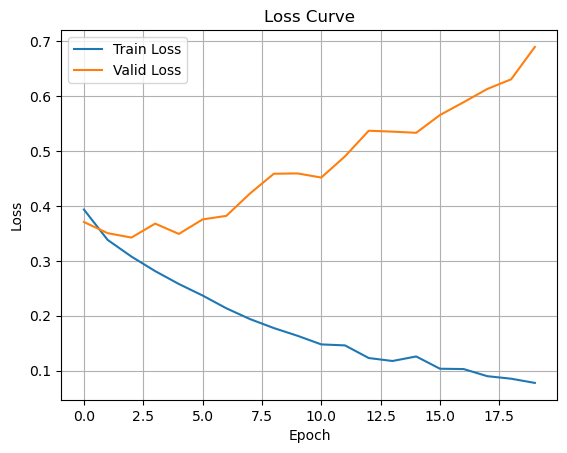

In [15]:
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Valid Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.grid()
plt.show()

In [16]:
model.load_state_dict(torch.load('my_word2vec_rnn.pth'))
model.to(device)
model.eval()
test_loss = 0
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        test_loss += loss.item()
        preds = (outputs > 0.5).float()
        correct += (preds == labels).sum().item()
        total += labels.size(0)

avg_test_loss = test_loss / len(test_loader)
test_acc = correct / total

print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

Test Loss: 0.3752, Test Accuracy: 0.8509


In [17]:
hidden_size = 128
model = LSTMClassifier(embedding_layer, hidden_size)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [18]:
num_epochs = 20
train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []
best_valid_acc = 0.0

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    correct = 0
    total = 0

    for inputs, labels in tqdm(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        preds = (outputs > 0.5).float()
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    avg_train_loss = train_loss / len(train_loader)
    train_acc = correct / total

    train_losses.append(avg_train_loss)
    train_accuracies.append(train_acc)

    model.eval()
    valid_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in tqdm(valid_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            valid_loss += loss.item()
            preds = (outputs > 0.5).float()
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    avg_valid_loss = valid_loss / len(valid_loader)
    valid_acc = correct / total

    valid_losses.append(avg_valid_loss)
    valid_accuracies.append(valid_acc)
    
    if valid_acc > best_valid_acc:
        best_valid_acc = valid_acc
        torch.save(model.state_dict(), 'my_word2vec_lstm.pth')

    print(f'Epoch [{epoch+1}/{num_epochs}]')
    print(f'Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.4f}')
    print(f'Valid Loss: {avg_valid_loss:.4f}, Valid Acc: {valid_acc:.4f}')

100%|██████████| 457/457 [00:00<00:00, 667.35it/s]


Epoch [1/20]
Train Loss: 0.2845, Train Acc: 0.8749
Valid Loss: 0.3380, Valid Acc: 0.8516


100%|██████████| 457/457 [00:00<00:00, 667.19it/s]


Epoch [2/20]
Train Loss: 0.2249, Train Acc: 0.9059
Valid Loss: 0.3486, Valid Acc: 0.8560


100%|██████████| 457/457 [00:00<00:00, 665.21it/s]


Epoch [3/20]
Train Loss: 0.1936, Train Acc: 0.9209
Valid Loss: 0.3619, Valid Acc: 0.8505


100%|██████████| 457/457 [00:00<00:00, 667.35it/s]


Epoch [4/20]
Train Loss: 0.1688, Train Acc: 0.9321
Valid Loss: 0.3986, Valid Acc: 0.8550


100%|██████████| 457/457 [00:00<00:00, 672.51it/s]


Epoch [5/20]
Train Loss: 0.1405, Train Acc: 0.9452
Valid Loss: 0.4412, Valid Acc: 0.8530


100%|██████████| 457/457 [00:00<00:00, 668.54it/s]


Epoch [6/20]
Train Loss: 0.1179, Train Acc: 0.9550
Valid Loss: 0.4892, Valid Acc: 0.8503


100%|██████████| 457/457 [00:00<00:00, 671.56it/s]


Epoch [7/20]
Train Loss: 0.0999, Train Acc: 0.9625
Valid Loss: 0.5331, Valid Acc: 0.8481


100%|██████████| 457/457 [00:00<00:00, 683.70it/s]


Epoch [8/20]
Train Loss: 0.0824, Train Acc: 0.9693
Valid Loss: 0.6189, Valid Acc: 0.8493


100%|██████████| 457/457 [00:00<00:00, 635.63it/s]


Epoch [9/20]
Train Loss: 0.0674, Train Acc: 0.9750
Valid Loss: 0.6857, Valid Acc: 0.8470


100%|██████████| 457/457 [00:00<00:00, 678.72it/s]


Epoch [10/20]
Train Loss: 0.0621, Train Acc: 0.9771
Valid Loss: 0.6551, Valid Acc: 0.8488


100%|██████████| 457/457 [00:00<00:00, 659.73it/s]


Epoch [11/20]
Train Loss: 0.0493, Train Acc: 0.9823
Valid Loss: 0.7879, Valid Acc: 0.8454


100%|██████████| 457/457 [00:00<00:00, 673.00it/s]


Epoch [12/20]
Train Loss: 0.0393, Train Acc: 0.9853
Valid Loss: 0.8943, Valid Acc: 0.8448


100%|██████████| 457/457 [00:00<00:00, 672.63it/s]


Epoch [13/20]
Train Loss: 0.0380, Train Acc: 0.9860
Valid Loss: 0.9069, Valid Acc: 0.8452


100%|██████████| 457/457 [00:00<00:00, 649.60it/s]


Epoch [14/20]
Train Loss: 0.0306, Train Acc: 0.9886
Valid Loss: 0.9808, Valid Acc: 0.8421


100%|██████████| 457/457 [00:00<00:00, 651.92it/s]


Epoch [15/20]
Train Loss: 0.0281, Train Acc: 0.9894
Valid Loss: 1.0325, Valid Acc: 0.8418


100%|██████████| 457/457 [00:00<00:00, 678.87it/s]


Epoch [16/20]
Train Loss: 0.0233, Train Acc: 0.9910
Valid Loss: 1.0393, Valid Acc: 0.8415


100%|██████████| 457/457 [00:00<00:00, 665.06it/s]


Epoch [17/20]
Train Loss: 0.0200, Train Acc: 0.9921
Valid Loss: 1.1298, Valid Acc: 0.8390


100%|██████████| 457/457 [00:00<00:00, 671.86it/s]


Epoch [18/20]
Train Loss: 0.0200, Train Acc: 0.9922
Valid Loss: 1.1229, Valid Acc: 0.8393


100%|██████████| 457/457 [00:00<00:00, 668.09it/s]


Epoch [19/20]
Train Loss: 0.0179, Train Acc: 0.9928
Valid Loss: 1.1453, Valid Acc: 0.8410


100%|██████████| 457/457 [00:00<00:00, 670.06it/s]

Epoch [20/20]
Train Loss: 0.0161, Train Acc: 0.9936
Valid Loss: 1.2243, Valid Acc: 0.8403


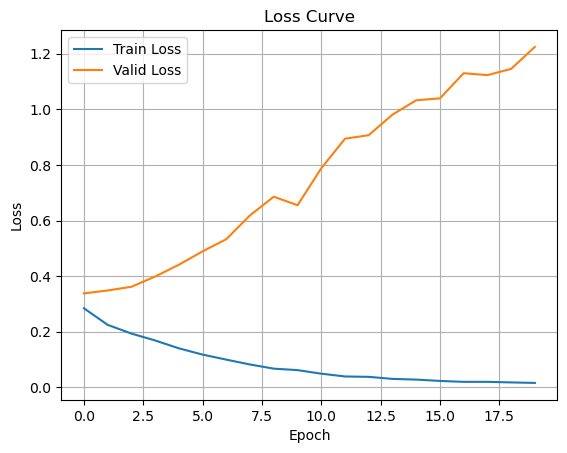

In [19]:
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Valid Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.grid()
plt.show()

In [20]:
model.load_state_dict(torch.load('my_word2vec_lstm.pth'))
model.to(device)
model.eval()
test_loss = 0
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        test_loss += loss.item()
        preds = (outputs > 0.5).float()
        correct += (preds == labels).sum().item()
        total += labels.size(0)

avg_test_loss = test_loss / len(test_loader)
test_acc = correct / total

print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

Test Loss: 0.3512, Test Accuracy: 0.8562


In [21]:
output_size = 1
model = CNNClassifier(embedding_layer, output_size)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [22]:
num_epochs = 20
train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []
best_valid_acc = 0.0

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    correct = 0
    total = 0

    for inputs, labels in tqdm(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        preds = (outputs > 0.5).float()
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    avg_train_loss = train_loss / len(train_loader)
    train_acc = correct / total

    train_losses.append(avg_train_loss)
    train_accuracies.append(train_acc)

    model.eval()
    valid_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in tqdm(valid_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            valid_loss += loss.item()
            preds = (outputs > 0.5).float()
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    avg_valid_loss = valid_loss / len(valid_loader)
    valid_acc = correct / total

    valid_losses.append(avg_valid_loss)
    valid_accuracies.append(valid_acc)
    
    if valid_acc > best_valid_acc:
        best_valid_acc = valid_acc
        torch.save(model.state_dict(), 'my_word2vec_cnn.pth')

    print(f'Epoch [{epoch+1}/{num_epochs}]')
    print(f'Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.4f}')
    print(f'Valid Loss: {avg_valid_loss:.4f}, Valid Acc: {valid_acc:.4f}')

100%|██████████| 457/457 [00:00<00:00, 719.87it/s]


Epoch [1/20]
Train Loss: 0.2995, Train Acc: 0.8688
Valid Loss: 0.3372, Valid Acc: 0.8497


100%|██████████| 457/457 [00:00<00:00, 705.26it/s]


Epoch [2/20]
Train Loss: 0.2501, Train Acc: 0.8937
Valid Loss: 0.3296, Valid Acc: 0.8562


100%|██████████| 457/457 [00:00<00:00, 717.98it/s]


Epoch [3/20]
Train Loss: 0.2198, Train Acc: 0.9071
Valid Loss: 0.3600, Valid Acc: 0.8551


100%|██████████| 457/457 [00:00<00:00, 739.61it/s]


Epoch [4/20]
Train Loss: 0.1950, Train Acc: 0.9189
Valid Loss: 0.3734, Valid Acc: 0.8601


100%|██████████| 457/457 [00:00<00:00, 710.49it/s]


Epoch [5/20]
Train Loss: 0.1722, Train Acc: 0.9297
Valid Loss: 0.4013, Valid Acc: 0.8542


100%|██████████| 457/457 [00:00<00:00, 727.01it/s]


Epoch [6/20]
Train Loss: 0.1532, Train Acc: 0.9372
Valid Loss: 0.4392, Valid Acc: 0.8514


100%|██████████| 457/457 [00:00<00:00, 740.90it/s]


Epoch [7/20]
Train Loss: 0.1354, Train Acc: 0.9455
Valid Loss: 0.4775, Valid Acc: 0.8524


100%|██████████| 457/457 [00:00<00:00, 688.41it/s]


Epoch [8/20]
Train Loss: 0.1202, Train Acc: 0.9516
Valid Loss: 0.5512, Valid Acc: 0.8521


100%|██████████| 457/457 [00:00<00:00, 707.89it/s]


Epoch [9/20]
Train Loss: 0.1102, Train Acc: 0.9561
Valid Loss: 0.5772, Valid Acc: 0.8510


100%|██████████| 457/457 [00:00<00:00, 742.48it/s]


Epoch [10/20]
Train Loss: 0.0995, Train Acc: 0.9605
Valid Loss: 0.6002, Valid Acc: 0.8467


100%|██████████| 457/457 [00:00<00:00, 714.70it/s]


Epoch [11/20]
Train Loss: 0.0913, Train Acc: 0.9636
Valid Loss: 0.6413, Valid Acc: 0.8439


100%|██████████| 457/457 [00:00<00:00, 739.75it/s]


Epoch [12/20]
Train Loss: 0.0840, Train Acc: 0.9670
Valid Loss: 0.7091, Valid Acc: 0.8469


100%|██████████| 457/457 [00:00<00:00, 735.29it/s]


Epoch [13/20]
Train Loss: 0.0777, Train Acc: 0.9691
Valid Loss: 0.7471, Valid Acc: 0.8451


100%|██████████| 457/457 [00:00<00:00, 685.76it/s]


Epoch [14/20]
Train Loss: 0.0724, Train Acc: 0.9712
Valid Loss: 0.7829, Valid Acc: 0.8454


100%|██████████| 457/457 [00:00<00:00, 742.24it/s]


Epoch [15/20]
Train Loss: 0.0711, Train Acc: 0.9717
Valid Loss: 0.8090, Valid Acc: 0.8436


100%|██████████| 457/457 [00:00<00:00, 730.53it/s]


Epoch [16/20]
Train Loss: 0.0654, Train Acc: 0.9742
Valid Loss: 0.8862, Valid Acc: 0.8459


100%|██████████| 457/457 [00:00<00:00, 710.85it/s]


Epoch [17/20]
Train Loss: 0.0621, Train Acc: 0.9755
Valid Loss: 0.8988, Valid Acc: 0.8427


100%|██████████| 457/457 [00:00<00:00, 705.26it/s]


Epoch [18/20]
Train Loss: 0.0605, Train Acc: 0.9762
Valid Loss: 0.9307, Valid Acc: 0.8426


100%|██████████| 457/457 [00:00<00:00, 738.77it/s]


Epoch [19/20]
Train Loss: 0.0567, Train Acc: 0.9784
Valid Loss: 0.9930, Valid Acc: 0.8433


100%|██████████| 457/457 [00:00<00:00, 705.20it/s]

Epoch [20/20]
Train Loss: 0.0555, Train Acc: 0.9778
Valid Loss: 0.9889, Valid Acc: 0.8407


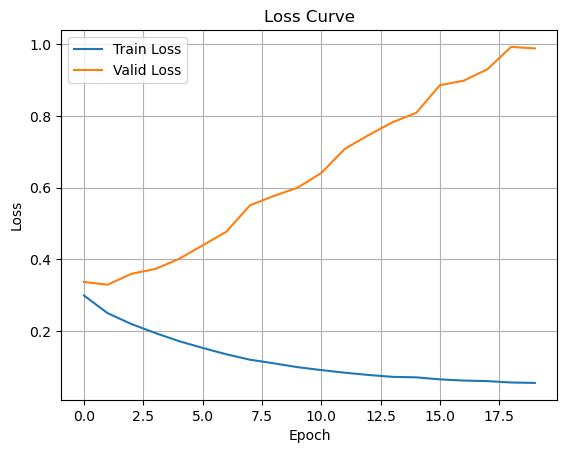

In [23]:
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Valid Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.grid()
plt.show()

In [24]:
model.load_state_dict(torch.load('my_word2vec_cnn.pth'))
model.to(device)
model.eval()
test_loss = 0
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        test_loss += loss.item()
        preds = (outputs > 0.5).float()
        correct += (preds == labels).sum().item()
        total += labels.size(0)

avg_test_loss = test_loss / len(test_loader)
test_acc = correct / total

print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

Test Loss: 0.3796, Test Accuracy: 0.8573


In [25]:
word2vec_ko_model = Word2Vec.load('word2vec_ko.model')

embedding_dim = 100
vocab_size = len(word_to_index)

embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, idx in word_to_index.items():
    if word in word2vec_ko_model.wv:
        embedding_matrix[idx] = word2vec_ko_model.wv[word]
    else:
        embedding_matrix[idx] = np.random.normal(scale=0.6, size=(embedding_dim, ))

embedding_layer = nn.Embedding.from_pretrained(torch.FloatTensor(embedding_matrix), freeze=False)

In [26]:
hidden_size = 128
model = RNNClassifier(embedding_layer, hidden_size)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [27]:
num_epochs = 20
train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []
best_valid_acc = 0.0

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    correct = 0
    total = 0

    for inputs, labels in tqdm(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        preds = (outputs > 0.5).float()
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    avg_train_loss = train_loss / len(train_loader)
    train_acc = correct / total

    train_losses.append(avg_train_loss)
    train_accuracies.append(train_acc)

    model.eval()
    valid_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in tqdm(valid_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            valid_loss += loss.item()
            preds = (outputs > 0.5).float()
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    avg_valid_loss = valid_loss / len(valid_loader)
    valid_acc = correct / total

    valid_losses.append(avg_valid_loss)
    valid_accuracies.append(valid_acc)
    
    if valid_acc > best_valid_acc:
        best_valid_acc = valid_acc
        torch.save(model.state_dict(), 'word2vec_ko_rnn.pth')

    print(f'Epoch [{epoch+1}/{num_epochs}]')
    print(f'Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.4f}')
    print(f'Valid Loss: {avg_valid_loss:.4f}, Valid Acc: {valid_acc:.4f}')

100%|██████████| 457/457 [00:00<00:00, 871.55it/s]


Epoch [1/20]
Train Loss: 0.4876, Train Acc: 0.7582
Valid Loss: 0.4247, Valid Acc: 0.8186


100%|██████████| 457/457 [00:00<00:00, 868.58it/s]


Epoch [2/20]
Train Loss: 0.3835, Train Acc: 0.8255
Valid Loss: 0.3783, Valid Acc: 0.8369


100%|██████████| 457/457 [00:00<00:00, 884.22it/s]


Epoch [3/20]
Train Loss: 0.3504, Train Acc: 0.8443
Valid Loss: 0.3587, Valid Acc: 0.8388


100%|██████████| 457/457 [00:00<00:00, 887.64it/s]


Epoch [4/20]
Train Loss: 0.3469, Train Acc: 0.8467
Valid Loss: 0.3734, Valid Acc: 0.8295


100%|██████████| 457/457 [00:00<00:00, 872.54it/s]


Epoch [5/20]
Train Loss: 0.3320, Train Acc: 0.8560
Valid Loss: 0.3476, Valid Acc: 0.8495


100%|██████████| 457/457 [00:00<00:00, 870.41it/s]


Epoch [6/20]
Train Loss: 0.3019, Train Acc: 0.8715
Valid Loss: 0.3452, Valid Acc: 0.8531


100%|██████████| 457/457 [00:00<00:00, 850.55it/s]


Epoch [7/20]
Train Loss: 0.3001, Train Acc: 0.8710
Valid Loss: 0.3657, Valid Acc: 0.8412


100%|██████████| 457/457 [00:00<00:00, 859.88it/s]


Epoch [8/20]
Train Loss: 0.2926, Train Acc: 0.8757
Valid Loss: 0.3522, Valid Acc: 0.8517


100%|██████████| 457/457 [00:00<00:00, 899.20it/s]


Epoch [9/20]
Train Loss: 0.2833, Train Acc: 0.8807
Valid Loss: 0.3528, Valid Acc: 0.8545


100%|██████████| 457/457 [00:00<00:00, 862.53it/s]


Epoch [10/20]
Train Loss: 0.2771, Train Acc: 0.8838
Valid Loss: 0.3586, Valid Acc: 0.8456


100%|██████████| 457/457 [00:00<00:00, 866.58it/s]


Epoch [11/20]
Train Loss: 0.3025, Train Acc: 0.8695
Valid Loss: 0.3573, Valid Acc: 0.8485


100%|██████████| 457/457 [00:00<00:00, 799.00it/s]


Epoch [12/20]
Train Loss: 0.3186, Train Acc: 0.8605
Valid Loss: 0.3680, Valid Acc: 0.8439


100%|██████████| 457/457 [00:00<00:00, 884.76it/s]


Epoch [13/20]
Train Loss: 0.2698, Train Acc: 0.8871
Valid Loss: 0.3669, Valid Acc: 0.8508


100%|██████████| 457/457 [00:00<00:00, 869.51it/s]


Epoch [14/20]
Train Loss: 0.2635, Train Acc: 0.8912
Valid Loss: 0.3608, Valid Acc: 0.8445


100%|██████████| 457/457 [00:00<00:00, 777.93it/s]


Epoch [15/20]
Train Loss: 0.2691, Train Acc: 0.8866
Valid Loss: 0.4172, Valid Acc: 0.8197


100%|██████████| 457/457 [00:00<00:00, 860.43it/s]


Epoch [16/20]
Train Loss: 0.2788, Train Acc: 0.8840
Valid Loss: 0.3561, Valid Acc: 0.8478


100%|██████████| 457/457 [00:00<00:00, 889.46it/s]


Epoch [17/20]
Train Loss: 0.2467, Train Acc: 0.8993
Valid Loss: 0.3625, Valid Acc: 0.8457


100%|██████████| 457/457 [00:00<00:00, 874.42it/s]


Epoch [18/20]
Train Loss: 0.2445, Train Acc: 0.8990
Valid Loss: 0.3783, Valid Acc: 0.8530


100%|██████████| 457/457 [00:00<00:00, 882.90it/s]


Epoch [19/20]
Train Loss: 0.2491, Train Acc: 0.8978
Valid Loss: 0.3735, Valid Acc: 0.8533


100%|██████████| 457/457 [00:00<00:00, 845.83it/s]

Epoch [20/20]
Train Loss: 0.2342, Train Acc: 0.9049
Valid Loss: 0.3764, Valid Acc: 0.8544


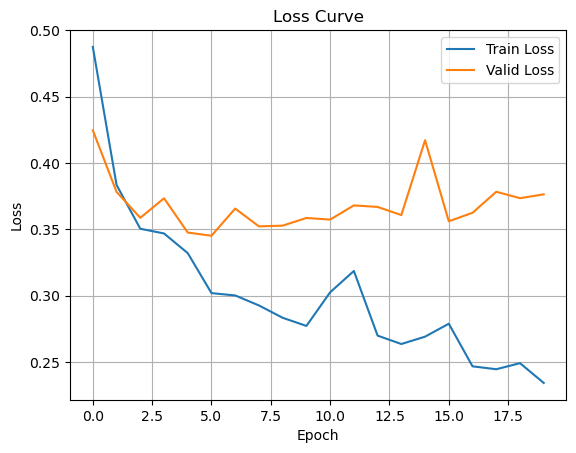

In [28]:
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Valid Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.grid()
plt.show()

In [29]:
model.load_state_dict(torch.load('word2vec_ko_rnn.pth'))
model.to(device)
model.eval()
test_loss = 0
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        test_loss += loss.item()
        preds = (outputs > 0.5).float()
        correct += (preds == labels).sum().item()
        total += labels.size(0)

avg_test_loss = test_loss / len(test_loader)
test_acc = correct / total

print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

Test Loss: 0.3544, Test Accuracy: 0.8503


In [30]:
hidden_size = 128
model = LSTMClassifier(embedding_layer, hidden_size)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [31]:
num_epochs = 20
train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []
best_valid_acc = 0.0

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    correct = 0
    total = 0

    for inputs, labels in tqdm(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        preds = (outputs > 0.5).float()
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    avg_train_loss = train_loss / len(train_loader)
    train_acc = correct / total

    train_losses.append(avg_train_loss)
    train_accuracies.append(train_acc)

    model.eval()
    valid_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in tqdm(valid_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            valid_loss += loss.item()
            preds = (outputs > 0.5).float()
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    avg_valid_loss = valid_loss / len(valid_loader)
    valid_acc = correct / total

    valid_losses.append(avg_valid_loss)
    valid_accuracies.append(valid_acc)
    
    if valid_acc > best_valid_acc:
        best_valid_acc = valid_acc
        torch.save(model.state_dict(), 'word2vec_ko_lstm.pth')

    print(f'Epoch [{epoch+1}/{num_epochs}]')
    print(f'Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.4f}')
    print(f'Valid Loss: {avg_valid_loss:.4f}, Valid Acc: {valid_acc:.4f}')

100%|██████████| 457/457 [00:00<00:00, 670.75it/s]


Epoch [1/20]
Train Loss: 0.3136, Train Acc: 0.8591
Valid Loss: 0.3272, Valid Acc: 0.8635


100%|██████████| 457/457 [00:00<00:00, 662.86it/s]


Epoch [2/20]
Train Loss: 0.2654, Train Acc: 0.8860
Valid Loss: 0.3189, Valid Acc: 0.8617


100%|██████████| 457/457 [00:00<00:00, 666.93it/s]


Epoch [3/20]
Train Loss: 0.2405, Train Acc: 0.8980
Valid Loss: 0.3446, Valid Acc: 0.8654


100%|██████████| 457/457 [00:00<00:00, 613.96it/s]


Epoch [4/20]
Train Loss: 0.2147, Train Acc: 0.9103
Valid Loss: 0.3361, Valid Acc: 0.8650


100%|██████████| 457/457 [00:00<00:00, 655.97it/s]


Epoch [5/20]
Train Loss: 0.1904, Train Acc: 0.9214
Valid Loss: 0.3487, Valid Acc: 0.8642


100%|██████████| 457/457 [00:00<00:00, 670.95it/s]


Epoch [6/20]
Train Loss: 0.1635, Train Acc: 0.9339
Valid Loss: 0.3757, Valid Acc: 0.8640


100%|██████████| 457/457 [00:00<00:00, 666.64it/s]


Epoch [7/20]
Train Loss: 0.1402, Train Acc: 0.9445
Valid Loss: 0.4086, Valid Acc: 0.8608


100%|██████████| 457/457 [00:00<00:00, 678.81it/s]


Epoch [8/20]
Train Loss: 0.1182, Train Acc: 0.9542
Valid Loss: 0.4513, Valid Acc: 0.8574


100%|██████████| 457/457 [00:00<00:00, 669.68it/s]


Epoch [9/20]
Train Loss: 0.0972, Train Acc: 0.9634
Valid Loss: 0.4858, Valid Acc: 0.8549


100%|██████████| 457/457 [00:00<00:00, 638.37it/s]


Epoch [10/20]
Train Loss: 0.0816, Train Acc: 0.9691
Valid Loss: 0.5356, Valid Acc: 0.8538


100%|██████████| 457/457 [00:00<00:00, 671.58it/s]


Epoch [11/20]
Train Loss: 0.0681, Train Acc: 0.9746
Valid Loss: 0.5962, Valid Acc: 0.8535


100%|██████████| 457/457 [00:00<00:00, 664.14it/s]


Epoch [12/20]
Train Loss: 0.0623, Train Acc: 0.9770
Valid Loss: 0.6152, Valid Acc: 0.8551


100%|██████████| 457/457 [00:00<00:00, 665.69it/s]


Epoch [13/20]
Train Loss: 0.0492, Train Acc: 0.9818
Valid Loss: 0.7093, Valid Acc: 0.8541


100%|██████████| 457/457 [00:00<00:00, 624.93it/s]


Epoch [14/20]
Train Loss: 0.0452, Train Acc: 0.9833
Valid Loss: 0.7108, Valid Acc: 0.8513


100%|██████████| 457/457 [00:00<00:00, 653.31it/s]


Epoch [15/20]
Train Loss: 0.0438, Train Acc: 0.9836
Valid Loss: 0.7285, Valid Acc: 0.8513


100%|██████████| 457/457 [00:00<00:00, 663.84it/s]


Epoch [16/20]
Train Loss: 0.0358, Train Acc: 0.9865
Valid Loss: 0.8214, Valid Acc: 0.8514


100%|██████████| 457/457 [00:00<00:00, 629.81it/s]


Epoch [17/20]
Train Loss: 0.0362, Train Acc: 0.9862
Valid Loss: 0.7944, Valid Acc: 0.8499


100%|██████████| 457/457 [00:00<00:00, 671.95it/s]


Epoch [18/20]
Train Loss: 0.0341, Train Acc: 0.9871
Valid Loss: 0.8282, Valid Acc: 0.8500


100%|██████████| 457/457 [00:00<00:00, 675.88it/s]


Epoch [19/20]
Train Loss: 0.0272, Train Acc: 0.9900
Valid Loss: 0.8478, Valid Acc: 0.8475


100%|██████████| 457/457 [00:00<00:00, 657.23it/s]

Epoch [20/20]
Train Loss: 0.0268, Train Acc: 0.9898
Valid Loss: 0.9141, Valid Acc: 0.8490


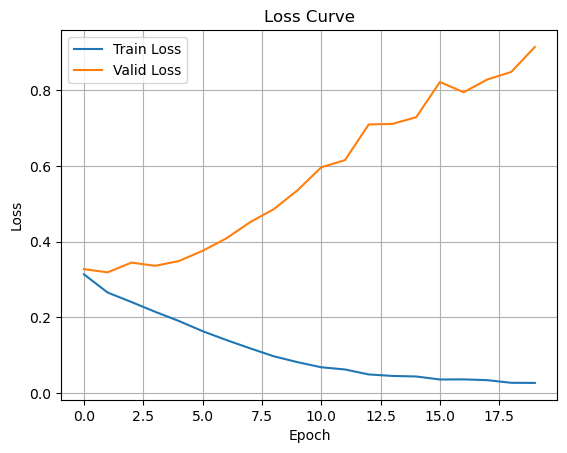

In [32]:
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Valid Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.grid()
plt.show()

In [33]:
model.load_state_dict(torch.load('word2vec_ko_lstm.pth'))
model.to(device)
model.eval()
test_loss = 0
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        test_loss += loss.item()
        preds = (outputs > 0.5).float()
        correct += (preds == labels).sum().item()
        total += labels.size(0)

avg_test_loss = test_loss / len(test_loader)
test_acc = correct / total

print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

Test Loss: 0.3481, Test Accuracy: 0.8623


In [34]:
output_size = 1
model = CNNClassifier(embedding_layer, output_size)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [35]:
num_epochs = 20
train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []
best_valid_acc = 0.0

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    correct = 0
    total = 0

    for inputs, labels in tqdm(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        preds = (outputs > 0.5).float()
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    avg_train_loss = train_loss / len(train_loader)
    train_acc = correct / total

    train_losses.append(avg_train_loss)
    train_accuracies.append(train_acc)

    model.eval()
    valid_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in tqdm(valid_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            valid_loss += loss.item()
            preds = (outputs > 0.5).float()
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    avg_valid_loss = valid_loss / len(valid_loader)
    valid_acc = correct / total

    valid_losses.append(avg_valid_loss)
    valid_accuracies.append(valid_acc)
    
    if valid_acc > best_valid_acc:
        best_valid_acc = valid_acc
        torch.save(model.state_dict(), 'word2vec_ko_cnn.pth')

    print(f'Epoch [{epoch+1}/{num_epochs}]')
    print(f'Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.4f}')
    print(f'Valid Loss: {avg_valid_loss:.4f}, Valid Acc: {valid_acc:.4f}')

100%|██████████| 457/457 [00:00<00:00, 714.01it/s]


Epoch [1/20]
Train Loss: 0.3546, Train Acc: 0.8394
Valid Loss: 0.3452, Valid Acc: 0.8496


100%|██████████| 457/457 [00:00<00:00, 639.01it/s]


Epoch [2/20]
Train Loss: 0.3055, Train Acc: 0.8671
Valid Loss: 0.3359, Valid Acc: 0.8529


100%|██████████| 457/457 [00:00<00:00, 718.99it/s]


Epoch [3/20]
Train Loss: 0.2906, Train Acc: 0.8735
Valid Loss: 0.3363, Valid Acc: 0.8533


100%|██████████| 457/457 [00:00<00:00, 725.76it/s]


Epoch [4/20]
Train Loss: 0.2800, Train Acc: 0.8786
Valid Loss: 0.3443, Valid Acc: 0.8508


100%|██████████| 457/457 [00:00<00:00, 710.36it/s]


Epoch [5/20]
Train Loss: 0.2704, Train Acc: 0.8826
Valid Loss: 0.3415, Valid Acc: 0.8556


100%|██████████| 457/457 [00:00<00:00, 728.75it/s]


Epoch [6/20]
Train Loss: 0.2603, Train Acc: 0.8876
Valid Loss: 0.3438, Valid Acc: 0.8587


100%|██████████| 457/457 [00:00<00:00, 706.10it/s]


Epoch [7/20]
Train Loss: 0.2512, Train Acc: 0.8917
Valid Loss: 0.3522, Valid Acc: 0.8543


100%|██████████| 457/457 [00:00<00:00, 709.22it/s]


Epoch [8/20]
Train Loss: 0.2436, Train Acc: 0.8950
Valid Loss: 0.3599, Valid Acc: 0.8555


100%|██████████| 457/457 [00:00<00:00, 717.64it/s]


Epoch [9/20]
Train Loss: 0.2352, Train Acc: 0.8989
Valid Loss: 0.3658, Valid Acc: 0.8589


100%|██████████| 457/457 [00:00<00:00, 722.09it/s]


Epoch [10/20]
Train Loss: 0.2278, Train Acc: 0.9015
Valid Loss: 0.3817, Valid Acc: 0.8573


100%|██████████| 457/457 [00:00<00:00, 730.29it/s]


Epoch [11/20]
Train Loss: 0.2194, Train Acc: 0.9053
Valid Loss: 0.3792, Valid Acc: 0.8538


100%|██████████| 457/457 [00:00<00:00, 723.44it/s]


Epoch [12/20]
Train Loss: 0.2106, Train Acc: 0.9095
Valid Loss: 0.3878, Valid Acc: 0.8562


100%|██████████| 457/457 [00:00<00:00, 690.34it/s]


Epoch [13/20]
Train Loss: 0.2009, Train Acc: 0.9134
Valid Loss: 0.4031, Valid Acc: 0.8547


100%|██████████| 457/457 [00:00<00:00, 715.47it/s]


Epoch [14/20]
Train Loss: 0.1955, Train Acc: 0.9154
Valid Loss: 0.4169, Valid Acc: 0.8525


100%|██████████| 457/457 [00:00<00:00, 706.04it/s]


Epoch [15/20]
Train Loss: 0.1870, Train Acc: 0.9203
Valid Loss: 0.4387, Valid Acc: 0.8492


100%|██████████| 457/457 [00:00<00:00, 730.46it/s]


Epoch [16/20]
Train Loss: 0.1812, Train Acc: 0.9222
Valid Loss: 0.4505, Valid Acc: 0.8549


100%|██████████| 457/457 [00:00<00:00, 712.05it/s]


Epoch [17/20]
Train Loss: 0.1731, Train Acc: 0.9266
Valid Loss: 0.4768, Valid Acc: 0.8543


100%|██████████| 457/457 [00:00<00:00, 718.25it/s]


Epoch [18/20]
Train Loss: 0.1678, Train Acc: 0.9287
Valid Loss: 0.4716, Valid Acc: 0.8545


100%|██████████| 457/457 [00:00<00:00, 721.93it/s]


Epoch [19/20]
Train Loss: 0.1630, Train Acc: 0.9308
Valid Loss: 0.4942, Valid Acc: 0.8518


100%|██████████| 457/457 [00:00<00:00, 725.87it/s]

Epoch [20/20]
Train Loss: 0.1566, Train Acc: 0.9331
Valid Loss: 0.5215, Valid Acc: 0.8518


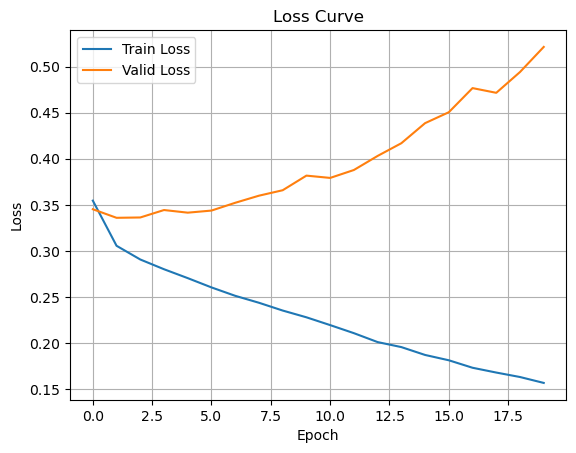

In [36]:
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Valid Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.grid()
plt.show()

In [37]:
model.load_state_dict(torch.load('word2vec_ko_cnn.pth'))
model.to(device)
model.eval()
test_loss = 0
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        test_loss += loss.item()
        preds = (outputs > 0.5).float()
        correct += (preds == labels).sum().item()
        total += labels.size(0)

avg_test_loss = test_loss / len(test_loader)
test_acc = correct / total

print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

Test Loss: 0.3686, Test Accuracy: 0.8565


In [38]:
# review
# 이번 프로젝트에서는 Skip-gram 기반 Word2Vec 임베딩을 직접 학습하여, 문장 분류 모델의 성능에 어떤 영향을 미치는지 확인하고 영화 리뷰 텍스트 김성분석을 진행하였다.
# Skip-gram 방식은 희소한 단어에 강하고, 문맥의 다양한 조합을 학습하는 데 유리하다는 장점이 있어 CBOW보다 일반적으로 더 정교한 단어 표현을 생성한다.
# 따라서 Skip-gram을 활용해 임베딩을 생성하였다. 또한 직접 학습한 Word2Vec 모델과 사전학습된 Word2Vec 모델 모두에 대해 RNN, LSTM, CNN 분류기를 구성하여 성능을 비교하였다.
# 직접 학습한 Skip-gram 기반 Word2Vec 임베딩은 전반적으로 문맥에 맞는 벡터를 잘 학습하였고, 특정 키워드에 대해 Top-10 유사도 단어를 추출했을 때, 
# 직접 학습한 모델보다 사전 학습 모델이 더 정밀하고 의미 있는 단어들을 잘 뽑아내는 경향을 보였다. 이는 사전학습된 모델이 훨씬 더 큰 코퍼스와 더 긴 학습 시간을 바탕으로 구축되었기 때문이다.
# 직접 학습한 Skip-gram 기반 Word2Vec 임베딩을 적용했을 때, RNN은 0.8509, LSTM은 0.8562, CNN은 0.8573의 정확도를 보였다. 
# 반면, 사전학습된 Word2Vec 임베딩을 활용한 경우 RNN은 0.8503, LSTM은 0.8623, CNN은 0.8565의 정확도를 보였다.
# 이번 프로젝트를 통해 좋은 임베딩이 주어졌을 때 LSTM이 가장 높은 성능을 발휘한다는 점을 확인할 수 있었다. 
# 이는 LSTM이 과거 정보를 장기적으로 유지하며, 각 시점의 입력을 더 정교하게 반영할 수 있는 구조적 특성을 갖고 있기 때문이다.
# 특히 좋은 임베딩은 단어 간 의미적 관계를 잘 표현하는데, LSTM은 이러한 의미 정보를 시퀀스 흐름 속에서 효과적으로 활용할 수 있어 성능 향상으로 이어졌다.
# 이를 통해 임베딩의 품질이 모델 성능에 큰 영향을 미친다는 사실도 확인할 수 있었다.
# 이미지 데이터를 학습할때와 다르게 에폭수를 많이 가져갈 필요가 없나? 싶었다. 텍스트는 에폭 단위로 모니터링하는게 아니라 배치 단위로 모니터링을 해야하는것인가... 
# 에폭수를 늘리니 과적합이 심하게 걸렸다. validation acc 기준으로 모델을 저장시켜서 문제될건 없었다.